# 
We hypothesize that stimulus-evoked changes in the LFP aperiodic offset reflect increased spiking activity in the underlying population. This notebook will investigate this hypothesis by computing stimulus-evoked changes in multi-unit spiking activity (MUA), and integrating these results with our previous spectral parameter results.  

## Set-up

#### Set path

In [1]:
# Define paths
PROJECT_PATH = r'G:\Shared drives\v1_v4_1024'


#### Imports

In [2]:
# general
import numpy as np
import matplotlib.pyplot as plt
import os
from neurodsp.utils import create_times
import pandas as pd

# custom
import sys
sys.path.append("../")
from scripts.utils import load_nix, epoch_neo_segment


#### Settings

In [3]:
# Session of interest (will ultimately apply to all sessions)
SESSIONS = ["A_SNR_041018", "A_SNR_140819", "L_SNR_250717"]
SESSION = "A_SNR_140819"

In [4]:
# Dataset details
N_ARRAYS = 16 # number of arrays per session
DURATION = 0.3 # duration of pre-/post-stimulus epoch (s)
T_MIN = -0.3 # minimum time (s)

#### Functions

## Main

#### Create output directory

In [5]:
# dir_out = f"{PROJECT_PATH}/figures/"
# if not os.path.exists(dir_out):
#     os.makedirs(dir_out)

#### load data

In [6]:
# load LFP spectral parameter results
results = pd.read_csv(fr"{PROJECT_PATH}\data\results\lfp_spectral_params.csv", index_col=0)
results

,session,channel,chan_idx,array,epoch,offset,knee,exponent,r2
0,A_SNR_041018,0,0,1,pre,8.816475,2737.235791,3.486568,0.998865
1,A_SNR_041018,1,1,1,pre,8.631928,2382.862075,3.412634,0.996765
2,A_SNR_041018,2,2,1,pre,8.151474,1142.595414,3.178614,0.996802
3,A_SNR_041018,3,3,1,pre,8.487444,2699.286151,3.391134,0.998620
4,A_SNR_041018,4,4,1,pre,8.229084,1406.120254,3.258810,0.997916
...,...,...,...,...,...,...,...,...,...
6139,L_SNR_250717,59,1019,16,post,8.072765,368.888266,2.765816,0.998221
6140,L_SNR_250717,60,1020,16,post,8.280201,823.197397,2.800549,0.999511
6141,L_SNR_250717,61,1021,16,post,8.571924,1261.398404,2.944253,0.999020
6142,L_SNR_250717,62,1022,16,post,8.790193,2288.213887,3.043717,0.998485


#### demo importing and plotting MUA data

Sampling rate: 1000.0 Hz
Signal duration: 0.064 s
N channels: 64
N trials: 102


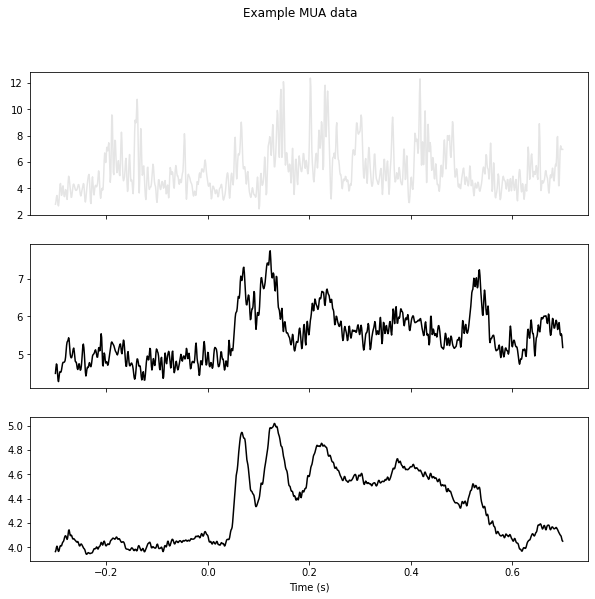

In [7]:
# load example MUA data
fname_in = r"C:\Users\micha\datasets\V1_v4_1024_electrode_resting_state_data\data\A_SNR_041018\MUAe\NSP1_array1_MUAe.nix"
segment, analog_signal = load_nix(fname_in)
signal = segment.analogsignals[0].T # transpose to get channels x time
fs = analog_signal._sampling_rate.item()

# epoch data into trials arouund stimulus times
epochs = epoch_neo_segment(segment, reset_time=True) 
epoch_times = create_times(epochs.shape[-1]/fs, fs, start_val=T_MIN) # get times for each epoch

# print info
print(f"Sampling rate: {fs} Hz")
print(f"Signal duration: {signal.duration.item()} s")
print(f"N channels: {signal.shape[0]}")
print(f"N trials: {len(segment.epochs[0])}")

# plot example trial, example channel, and grand average
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=[10,9], sharex=True)
fig.suptitle(f"Example MUA data")
ax1.plot(epoch_times, epochs[0,0,:].T, color="k", alpha=0.1) # plot first trial
ax2.plot(epoch_times, epochs[:,10,:].mean(axis=0), color="k") # plot first channel (mean across trials)
ax3.plot(epoch_times, epochs.mean(axis=(0,1)), color="k") # plot mean across all trials and channels
ax3.set_xlabel("Time (s)")
plt.show()


#### Compute average MUA for the pre-stimulus (-0.3 to 0.0 s) and post-stimulus (0.0 to 0.3 s) period.
add this information to the results dataframe imported above

#### Plot the stimulus-evoked change in the MUA v. the change in the LFP offset.